In [65]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Bidirectional
from tensorflow.keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import layers
from sklearn.preprocessing import StandardScaler

In [66]:
import pandas as pd
#https://machinelearningmastery.com/grid-search-hyperparameters-deep-learning-models-python-keras/
#https://www.kaggle.com/code/kratisaxena/lstm-gru-models-for-stock-movement-analysis

df = pd.read_csv('NFLX.csv')

high = df[['High']].dropna().values
low = df[['Low']].dropna().values
volume = df[['Volume']].dropna().values
# df['Close'] = df['Close'].rolling(5).mean()
df = df[['Close']].dropna()

close_real_prices = df.values
print(df)

           Close
0     254.259995
1     265.720001
2     264.559998
3     250.100006
4     249.470001
...          ...
1004  427.140015
1005  457.130005
1006  429.480011
1007  405.600006
1008  410.170013

[1009 rows x 1 columns]


In [67]:
window = 5
days = 5
batch = 16
prog = 0.70

dataset = df.values

# scaler = StandardScaler()
scaler = MinMaxScaler(feature_range=(0, 1))
volume = scaler.fit_transform(volume.reshape(-1, 1))
dataset  = scaler.fit_transform(dataset.reshape(-1, 1))
dataset

array([[0.04451626],
       [0.06954849],
       [0.06701469],
       ...,
       [0.4272515 ],
       [0.37509011],
       [0.38507243]])

In [68]:
def create_dataset(dataset, look_back):
    dataX, dataY = [], []
    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i+look_back), 0]
        dataX.append(a)
        dataY.append(dataset[i + look_back, 0])
    return np.array(dataX), np.array(dataY)

In [69]:
def windowed_set(dataset,window):


    prices = dataset[:,0]
    prices = prices.tolist()
    matrix = np.zeros((dataset.shape[0],window+1))


    for i in range(1,window+2):
        prices = np.array(prices)
        matrix[:, -i] = prices
        prices = prices.tolist()
        prices = [0] + prices[:-1]

    return matrix[window:]



In [70]:
windowed_data = windowed_set(dataset, window)
print(windowed_data)
treshold = int(len(dataset) * prog)

train, test = windowed_data[0:treshold,:], windowed_data[treshold:len(dataset),:]
initial_testset = test[-1]

X = windowed_data[:,:-2]
Y = windowed_data[:,-1]

trainX, trainY = train[:,:-1], train[:,-1]
testX, testY = test[:,:-1], test[:,-1]

trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))


[[0.04451626 0.06954849 0.06701469 0.03542955 0.03405342 0.05257641]
 [0.06954849 0.06701469 0.03542955 0.03405342 0.05257641 0.05327534]
 [0.06701469 0.03542955 0.03405342 0.05257641 0.05327534 0.0701601 ]
 ...
 [0.27483019 0.33380662 0.32869527 0.42214021 0.48764772 0.4272515 ]
 [0.33380662 0.32869527 0.42214021 0.48764772 0.4272515  0.37509011]
 [0.32869527 0.42214021 0.48764772 0.4272515  0.37509011 0.38507243]]


In [71]:
volume_train, volume_test = volume[0:treshold], volume[treshold:len(volume)]

In [72]:
callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=10)



model = Sequential()
model.add(LSTM(200, return_sequences=True, input_shape=(trainX.shape[1], window)))
model.add(LSTM(64, return_sequences=True))
model.add(LSTM(64, return_sequences=False))
# model.add(layers.GlobalAveragePooling1D())
model.add(layers.Dense(20))
model.add(layers.Dense(1))





model.compile(loss='mse', 
              optimizer=Adam(learning_rate=0.0001),
              metrics=['mean_absolute_error'])
model.fit(trainX, trainY, epochs = 500,batch_size=batch,callbacks=[callback])

Epoch 1/500
45/45 [==============================] - 3s 4ms/step - loss: 0.0929 - mean_absolute_error: 0.2624
Epoch 2/500
45/45 [==============================] - 0s 4ms/step - loss: 0.0608 - mean_absolute_error: 0.1982
Epoch 3/500
45/45 [==============================] - 0s 4ms/step - loss: 0.0266 - mean_absolute_error: 0.1200
Epoch 4/500
45/45 [==============================] - 0s 4ms/step - loss: 0.0108 - mean_absolute_error: 0.0830
Epoch 5/500
45/45 [==============================] - 0s 4ms/step - loss: 0.0083 - mean_absolute_error: 0.0774
Epoch 6/500
45/45 [==============================] - 0s 3ms/step - loss: 0.0062 - mean_absolute_error: 0.0652
Epoch 7/500
45/45 [==============================] - 0s 3ms/step - loss: 0.0043 - mean_absolute_error: 0.0543
Epoch 8/500
45/45 [==============================] - 0s 4ms/step - loss: 0.0029 - mean_absolute_error: 0.0434
Epoch 9/500
45/45 [==============================] - 0s 4ms/step - loss: 0.0020 - mean_absolute_error: 0.0350
Epoch 10/5

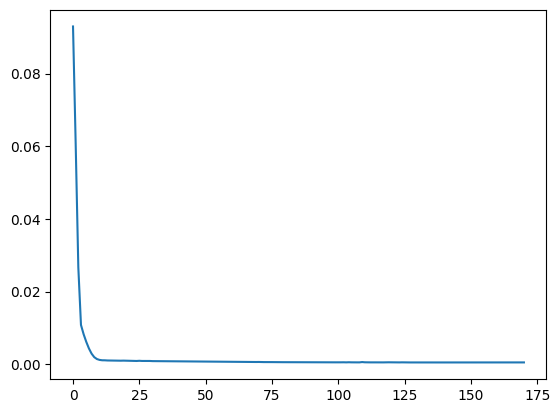

In [73]:
loss_per_epoch = model.history.history['loss']
plt.plot(range(len(loss_per_epoch)),loss_per_epoch)

Predictions for train set


23/23 [==============================] - 1s 2ms/step


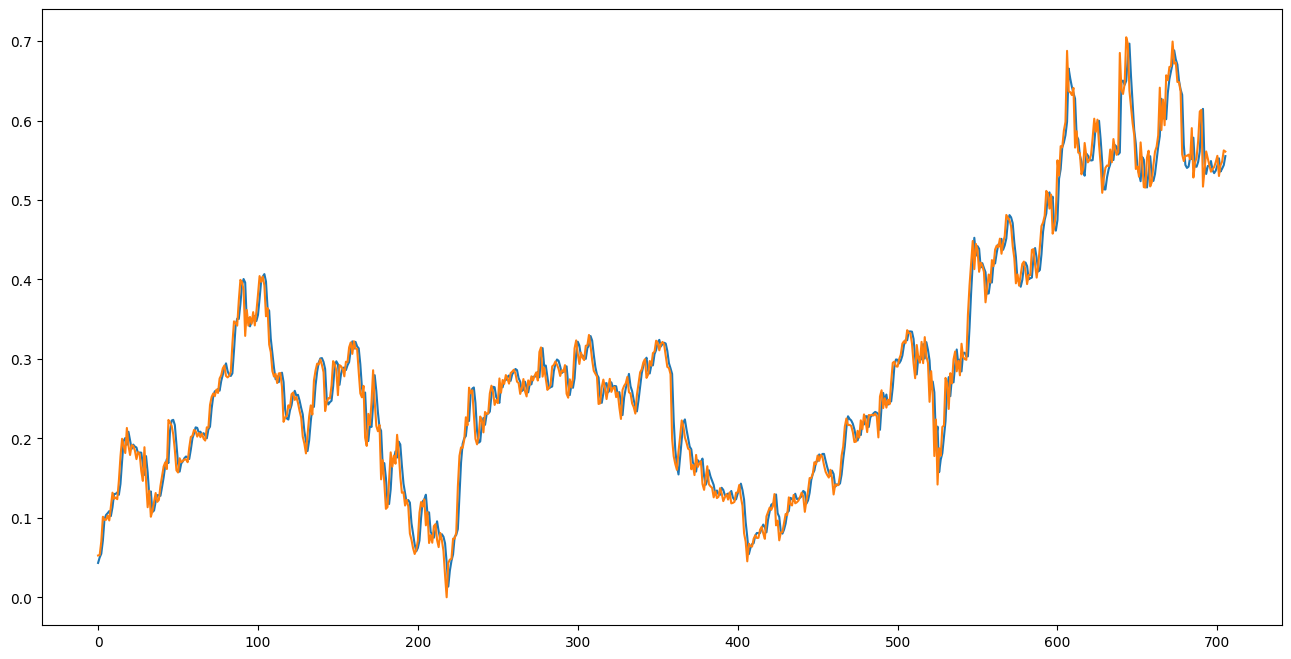

In [74]:
predicted_train = model.predict(trainX)

plt.figure(figsize=(16,8))
plt.plot(predicted_train[:,0].reshape(-1))

plt.plot(trainY)


One day prediction for test set


10/10 [==============================] - 0s 1ms/step
[0.5619062  0.58362556 0.58935213 0.5796389  0.57781535 0.6017463
 0.6073251  0.5791009  0.5797455  0.57902837 0.6135424  0.6268336
 0.63480824 0.65043783 0.65279824 0.64691925 0.63996273 0.61454505
 0.6052875  0.6128145  0.635256   0.63663596 0.6618323  0.63954395
 0.62476414 0.58934534 0.58556837 0.59471124 0.5787065  0.5705829
 0.58542746 0.5804891  0.57729095 0.5823441  0.7191854  0.7613812
 0.7490405  0.72574013 0.70032173 0.6401768  0.6480523  0.6428299
 0.6505132  0.6804683  0.6678426  0.68727523 0.68910736 0.6828069
 0.70217776 0.71173817 0.7067827  0.70333517 0.69953424 0.6885119
 0.681867   0.6661876  0.6500397  0.6670076  0.68594605 0.68363917
 0.67021406 0.6801892  0.6787628  0.6364506  0.6072091  0.6017118
 0.5656394  0.5822633  0.5857282  0.61521417 0.6247741  0.6247827
 0.63243747 0.63005775 0.600274   0.60028833 0.6180018  0.6448834
 0.63649005 0.5987261  0.59112996 0.5967995  0.60412306 0.62389857
 0.65651584 0.66875

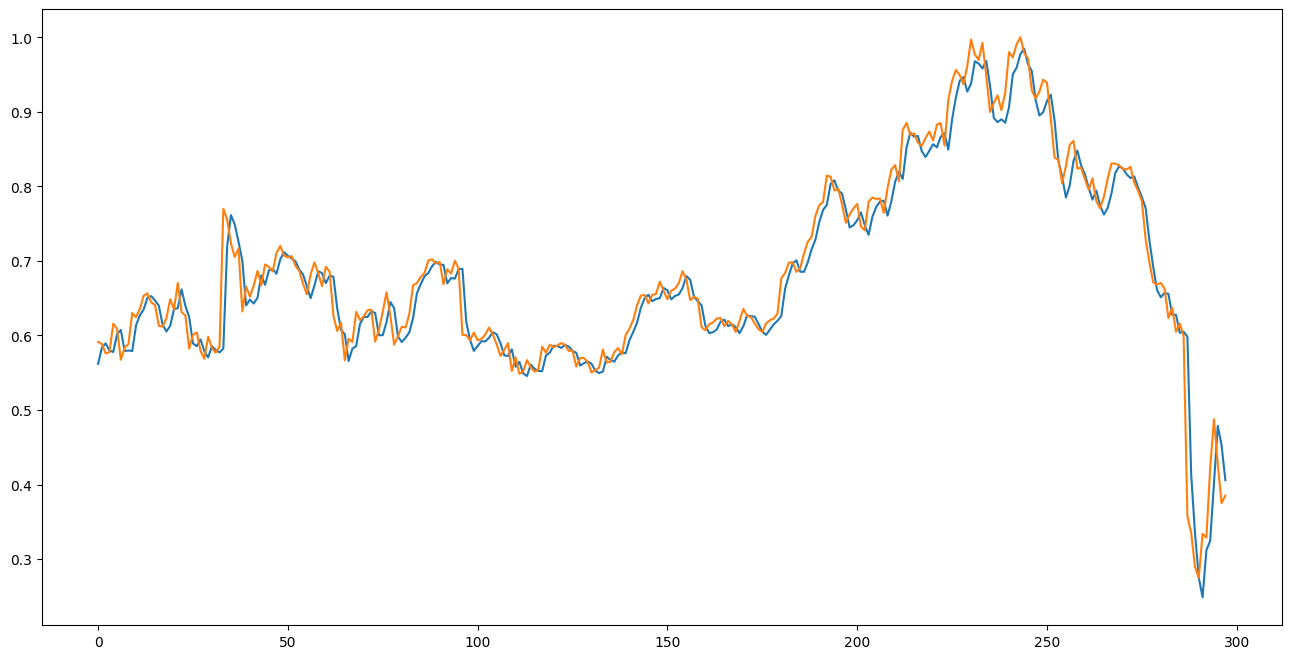

In [75]:

predicted = model.predict(testX)

print(predicted[:,0])

plt.figure(figsize=(16,8))
plt.plot(predicted[:,-1].reshape(-1))

plt.plot(testY)

In [76]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, explained_variance_score, r2_score 
from sklearn.metrics import mean_poisson_deviance, mean_gamma_deviance, accuracy_score

r2_train = r2_score(predicted[:,0].reshape(-1),testY)
print("Test data R2 score:", r2_train)

Test data R2 score: 0.9399861494873617


In [77]:
def series_predict(trainX,lenght_of_predictions):
    latest_prices = trainX
    x,y,z = latest_prices.shape
    
    predictions = model.predict(latest_prices)[-1][:lenght_of_predictions]
        
    return predictions

In [78]:

def recurrent_predict(trainX,lenght_of_predictions):
    predictions = []
    latest_prices = trainX
    x,y,z = latest_prices.shape
    for i in range(lenght_of_predictions):

        prediction = model.predict(latest_prices)[-1][0]
        print(prediction)
        predictions.append(prediction)
        temp_array = latest_prices[1:,:,:]
        last_row = temp_array[-1,:,:]
        temp_row = np.zeros(last_row.shape)
        
        
        for i in range(z-1):
            temp_row[0][i] = last_row[0][i+1]
        
        temp_row[0][-1] = prediction
        latest_prices = np.concatenate([latest_prices, temp_row[np.newaxis, :, :]], axis=0)

    
    return predictions

In [79]:
import math

each_week_prediction = window * [0]

rng = math.floor((int(len(dataset) * (1 - prog)))/days)
print(rng)
for i in range(rng):
    print(i,'/',rng)
    windowed_data = windowed_set(dataset, window)

    treshold = int(len(dataset) * prog+(i*days)) - window

    train = windowed_data[0:treshold,:]

    
    trainX, trainY = train[:,:-1], train[:,-1]
    trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
    

    current_week_predctions = recurrent_predict(trainX,days)
    for price in current_week_predctions:
        each_week_prediction.append(price)

    model.fit(trainX, trainY, epochs = 500,batch_size=batch,callbacks=[callback])

 

60
0 / 60
22/22 [==============================] - 0s 1ms/step
0.54365736
22/22 [==============================] - 0s 2ms/step
0.54360765
22/22 [==============================] - 0s 1ms/step
0.5425554
22/22 [==============================] - 0s 1ms/step
0.5411633
23/23 [==============================] - 0s 1ms/step
0.5389421
Epoch 1/500
44/44 [==============================] - 0s 3ms/step - loss: 4.8862e-04 - mean_absolute_error: 0.0161
Epoch 2/500
44/44 [==============================] - 0s 3ms/step - loss: 4.8727e-04 - mean_absolute_error: 0.0160
Epoch 3/500
44/44 [==============================] - 0s 3ms/step - loss: 4.8977e-04 - mean_absolute_error: 0.0162
Epoch 4/500
44/44 [==============================] - 0s 3ms/step - loss: 4.9307e-04 - mean_absolute_error: 0.0162
Epoch 5/500
44/44 [==============================] - 0s 3ms/step - loss: 4.9135e-04 - mean_absolute_error: 0.0160
Epoch 6/500
44/44 [==============================] - 0s 4ms/step - loss: 4.8379e-04 - mean_absolute_err

In [80]:
each_week_prediction = scaler.inverse_transform(np.array(each_week_prediction).reshape(-1,1))



5 days prediction made after each week (5 days)

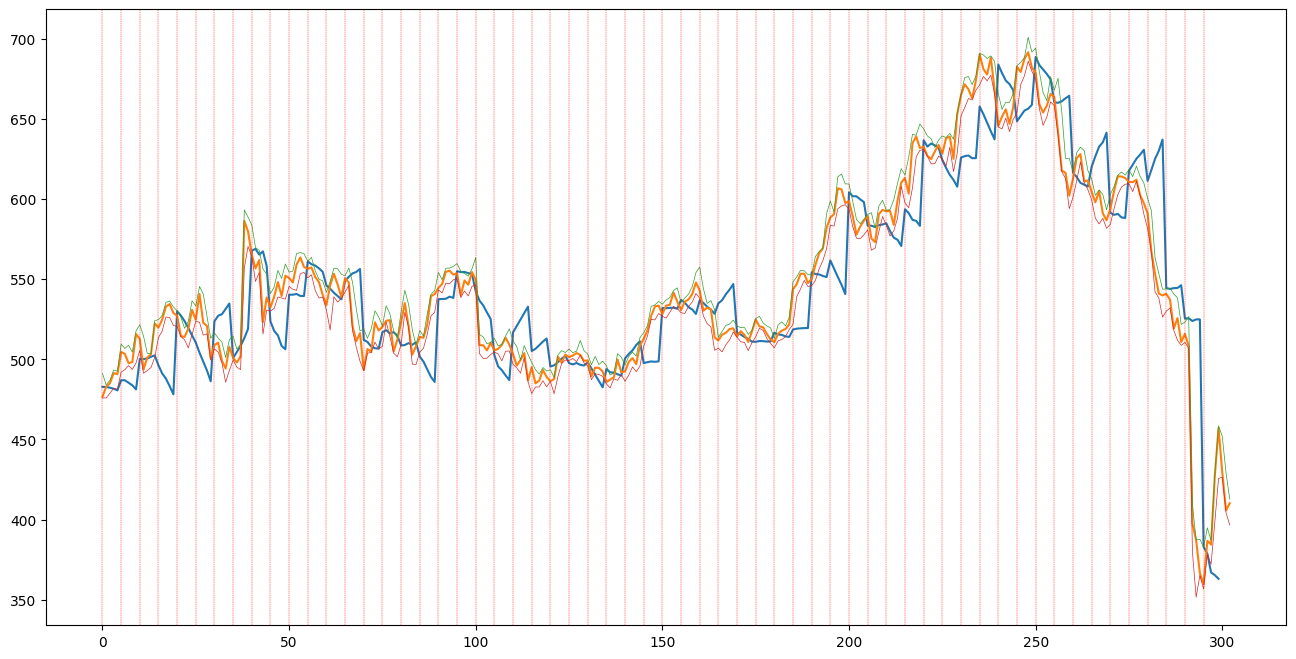

In [81]:
plt.figure(figsize=(16,8))

plt.plot(each_week_prediction[window:])
plt.plot(close_real_prices[int(len(dataset) * prog):])
plt.plot(high[int(len(dataset) * prog):],linewidth=0.5)
plt.plot(low[int(len(dataset) * prog):],linewidth=0.5)
for i in range(rng):
    plt.axvline(x=(i*days), color='r', linestyle='--',linewidth=0.3)

In [82]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, explained_variance_score, r2_score 
from sklearn.metrics import mean_poisson_deviance, mean_gamma_deviance, accuracy_score

r2_train = r2_score(close_real_prices[-len(each_week_prediction[window:]):], each_week_prediction[window:])
print("Test data R2 score:", r2_train)

Test data R2 score: 0.6234076712648897
